init


In [2]:
import numpy as np
import pandas as pd

# 1. 节点索引映射 (严格遵循您的 1-10 编号映射到 0-9)
NODE_MAP = {
    'OUTSET': 0,        # 编号 1
    'BEDROOM1': 1,      # 编号 2
    'BEDROOM2': 2,      # 编号 3
    'BEDROOM3': 3,      # 编号 4
    'BATH2': 4,         # 编号 5
    'BATH1': 5,         # 编号 6
    'KITCHEN': 7,       # 编号 8 (注意：对应图中的 8 号)
    'DININGROOM': 6,    # 编号 7 (注意：对应图中的 7 号)
    'LIVINGROOM': 8,    # 编号 9
    'HALL_FOYER': 9     # 编号 10
}
N_TOTAL = 10
N_ROOMS = 9 # 室内节点数

# 2. 房间体积向量 V (单位: m3)
# 索引 0 为 OUTSET，设为 np.inf
V = np.array([np.inf, 47.3, 42.9, 37.2, 14.6, 9.1, 30.4, 30.4, 47.3, 26.0])

# 3. 流量矩阵 Q (单位: m3/h)
# 直接根据您提供的表格数据进行矩阵硬编码
Q = np.array([
    [0, 3, 3, 3, 1, 0, 4, 4, 4, 1],   # Row 1 (OUTSET)
    [3, 0, 0, 0, 10, 0, 0, 0, 0, 10], # Row 2 (Bedroom 1)
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 3 (Bedroom 2)
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 4 (Bedroom 3)
    [1, 10, 0, 0, 0, 0, 0, 0, 0, 0],  # Row 5 (Bath 2)
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 6 (Bath 1)
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 7 (Dining Room)
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 8 (Kitchen)
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 9 (Living Room)
    [1, 10, 10, 10, 0, 10, 10, 10, 10, 0] # Row 10 (Hall+Foyer)
])

# 4. 物理与设备常量
C1 = 500.0           # 室外浓度 C1 (μg/m3)
C_INIT = 5.0         # 室内初始浓度 (μg/m3)
K_DEP = 0.1          # 附着系数 k (h-1)
ETA = 0.9            # 新风系统净化率 η
LAMBDA_NI = 0.5      # 新风系统换气次数 (h-1)
CADR_LIVING = 300.0  # 仅在客厅安装 (m3/h)

# 5. 换气次数矩阵 Lambda (用于微分方程计算)
# Lambda[j, i] = Q[j, i] / V[i]
with np.errstate(divide='ignore', invalid='ignore'):
    LAMBDA_MATRIX = Q / V[:, np.newaxis]
    LAMBDA_MATRIX = np.nan_to_num(LAMBDA_MATRIX)

# 输出结果以验证

print("节点索引映射 (NODE_MAP):")
print(NODE_MAP)
print("\n房间体积向量 (V):")
print(V)
print("\n流量矩阵 (Q):")
print(Q)
print("\n换气次数矩阵 (LAMBDA_MATRIX):")
print(LAMBDA_MATRIX)

节点索引映射 (NODE_MAP):
{'OUTSET': 0, 'BEDROOM1': 1, 'BEDROOM2': 2, 'BEDROOM3': 3, 'BATH2': 4, 'BATH1': 5, 'KITCHEN': 7, 'DININGROOM': 6, 'LIVINGROOM': 8, 'HALL_FOYER': 9}

房间体积向量 (V):
[ inf 47.3 42.9 37.2 14.6  9.1 30.4 30.4 47.3 26. ]

流量矩阵 (Q):
[[ 0  3  3  3  1  0  4  4  4  1]
 [ 3  0  0  0 10  0  0  0  0 10]
 [ 3  0  0  0  0  0  0  0  0 10]
 [ 3  0  0  0  0  0  0  0  0 10]
 [ 1 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 4  0  0  0  0  0  0  0  0 10]
 [ 4  0  0  0  0  0  0  0  0 10]
 [ 4  0  0  0  0  0  0  0  0 10]
 [ 1 10 10 10  0 10 10 10 10  0]]

换气次数矩阵 (LAMBDA_MATRIX):
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.06342495 0.         0.         0.         0.21141649 0.
  0.         0.         0.         0.21141649]
 [0.06993007 0.         0.         0.         0.         0.
  0.         0.         0.         0.23310023]
 [0.08064516 0.         0.         0.         0.         0.
  0.         0.     

In [3]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def air_quality_system(C, t, V, Q, LAMBDA_MATRIX, C1, K_DEP, ETA, LAMBDA_NI, CADR):
    """
    C: 当前时刻 9 个房间的浓度向量 [C2, C3, ..., C10]
    t: 时间步
    """
    dCdt = np.zeros(9)
    
    # 注意：C 数组索引 0-8 对应房间编号 2-10
    # 为了方便计算，我们将当前室内浓度和室外浓度拼成一个完整的 10 维向量
    C_full = np.concatenate(([C1], C)) 
    
    for i in range(1, 10): # 遍历房间编号 2 到 10 (索引从 1 到 9)
        # 1. 房间间交换项：输入 - 输出 [cite: 50, 51]
        # 输入：来自所有其他节点 j 的浓度贡献
        exchange_in = 0
        for j in range(10):
            if i != j:
                # λ_ji = Q[j, i] / V[i]
                exchange_in += (Q[j, i] / V[i]) * C_full[j]
        
        # 输出：从本房间流向所有其他节点 j 的污染物
        exchange_out = 0
        for j in range(10):
            if i != j:
                # λ_ij = Q[i, j] / V[i]
                exchange_out += (Q[i, j] / V[i]) * C_full[i]

        # 2. 新风系统项 
        # 新风输入经过过滤 (1-η)；等量排气直接排出
        fresh_air_term = (1 - ETA) * LAMBDA_NI * C1 - LAMBDA_NI * C_full[i]
        
        # 3. 沉积与净化器项 [cite: 53, 54]
        # CADR 仅在客厅 (索引 8) 有值，其余为 0
        purification_term = (K_DEP + (1 / V[i]) * CADR[i]) * C_full[i]
        
        # 4. 汇总方程 
        dCdt[i-1] = exchange_in - exchange_out + fresh_air_term - purification_term
        
    return dCdt

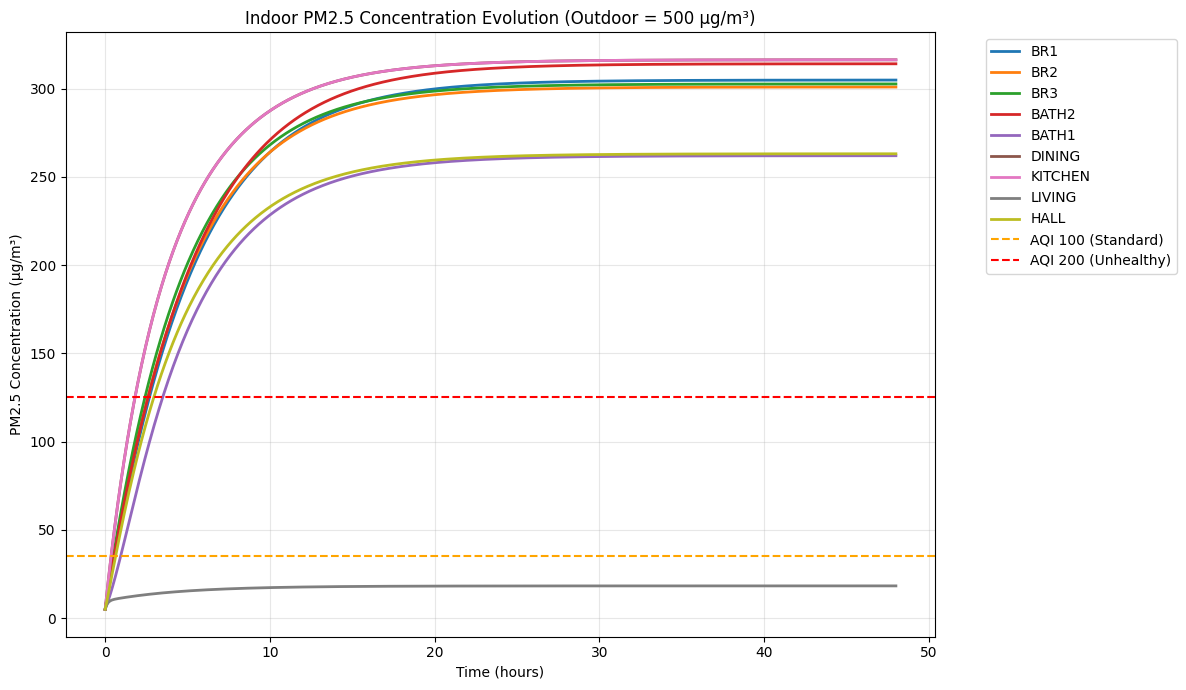

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ==========================================
# 1. 初始化与常量定义 [cite: 26, 27, 29, 34, 43]
# ==========================================
# 节点映射 (1-10 映射到 Python 索引 0-9)
NODE_MAP = {
    'OUTSET': 0, 'BEDROOM1': 1, 'BEDROOM2': 2, 'BEDROOM3': 3,
    'BATH2': 4, 'BATH1': 5, 'DININGROOM': 6, 'KITCHEN': 7, 
    'LIVINGROOM': 8, 'HALL_FOYER': 9
}
N_TOTAL = 10
N_ROOMS = 9

# 环境参数
C1 = 500.0           # 室外浓度 (μg/m3) [cite: 26]
C_INIT = 5.0         # 室内初始浓度 (μg/m3) [cite: 29]
K_DEP = 0.1          # 附着系数 k (h-1) [cite: 34] -—— 灵敏度分析
ETA = 0.9            # 新风系统净化率 η —— 灵敏度分析（0-1）
LAMBDA_NI = 0.5      # 新风系统换气次数 (h-1) 
CADR_VALUE = 300.0   # 客厅净化器 CADR (m3/h)  —— 灵敏度分析（0-500）

# 房间体积 V (单位: m3)
V = np.array([np.inf, 47.3, 42.9, 37.2, 14.6, 9.1, 30.4, 30.4, 47.3, 26.0])

# 流量矩阵 Q (单位: m3/h)
Q = np.zeros((N_TOTAL, N_TOTAL))
# ... (此处硬编码 Q 矩阵，基于您提供的表格数值)
Q_data = [
    [0, 3, 3, 3, 1, 0, 4, 4, 4, 1],   # Row 1
    [3, 0, 0, 0, 10, 0, 0, 0, 0, 10], # Row 2
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 3
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 4
    [1, 10, 0, 0, 0, 0, 0, 0, 0, 0],  # Row 5
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 6
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 7
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 8
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Row 9
    [1, 10, 10, 10, 0, 10, 10, 10, 10, 0] # Row 10
]
Q = np.array(Q_data)

# CADR 分布向量
CADR_VEC = np.zeros(N_TOTAL)
CADR_VEC[NODE_MAP['LIVINGROOM']] = CADR_VALUE

# ==========================================
# 2. 微分方程系统定义 
# ==========================================
def air_quality_model(C_rooms, t, V, Q, C1, K_DEP, ETA, LAMBDA_NI, CADR_VEC):
    # 将 9 个室内浓度与 1 个室外浓度合并
    C_full = np.concatenate(([C1], C_rooms))
    dCdt = np.zeros(N_ROOMS)
    
    for i in range(1, 10): # 遍历室内房间索引 1 到 9
        # 房间间交换：流入 - 流出
        # 流入项: sum(Q_ji * C_j) / V_i
        # 流出项: sum(Q_ij * C_i) / V_i
        in_term = np.sum(Q[:, i] * C_full) / V[i]
        out_term = np.sum(Q[i, :] * C_full[i]) / V[i]
        
        # 新风系统项 
        fresh_in = (1 - ETA) * LAMBDA_NI * C1
        fresh_out = LAMBDA_NI * C_full[i]
        
        # 自身消除项 (沉积 + 净化器) 
        removal = (K_DEP + CADR_VEC[i] / V[i]) * C_full[i]
        
        # 汇总
        dCdt[i-1] = in_term - out_term + fresh_in  - removal
        
    return dCdt

# ==========================================
# 3. 执行求解与结果后处理 [cite: 27, 29]
# ==========================================
t_span = np.linspace(0, 48, 1000) # 模拟 48 小时
C0 = np.full(N_ROOMS, C_INIT)    # 初始浓度 5.0 μg/m3 [cite: 29]

sol = odeint(air_quality_model, C0, t_span, 
             args=(V, Q, C1, K_DEP, ETA, LAMBDA_NI, CADR_VEC))

# 绘图可视化
plt.figure(figsize=(12, 7))
room_names = ['BR1', 'BR2', 'BR3', 'BATH2', 'BATH1', 'DINING', 'KITCHEN', 'LIVING', 'HALL']
for i in range(N_ROOMS):
    plt.plot(t_span, sol[:, i], label=room_names[i], linewidth=2)

# 绘制 AQI 警戒线 [cite: 27]
plt.axhline(y=35.4, color='orange', linestyle='--', label='AQI 100 (Standard)')
plt.axhline(y=125.4, color='red', linestyle='--', label='AQI 200 (Unhealthy)')

plt.title("Indoor PM2.5 Concentration Evolution (Outdoor = 500 μg/m³)")
plt.xlabel("Time (hours)")
plt.ylabel("PM2.5 Concentration (μg/m³)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



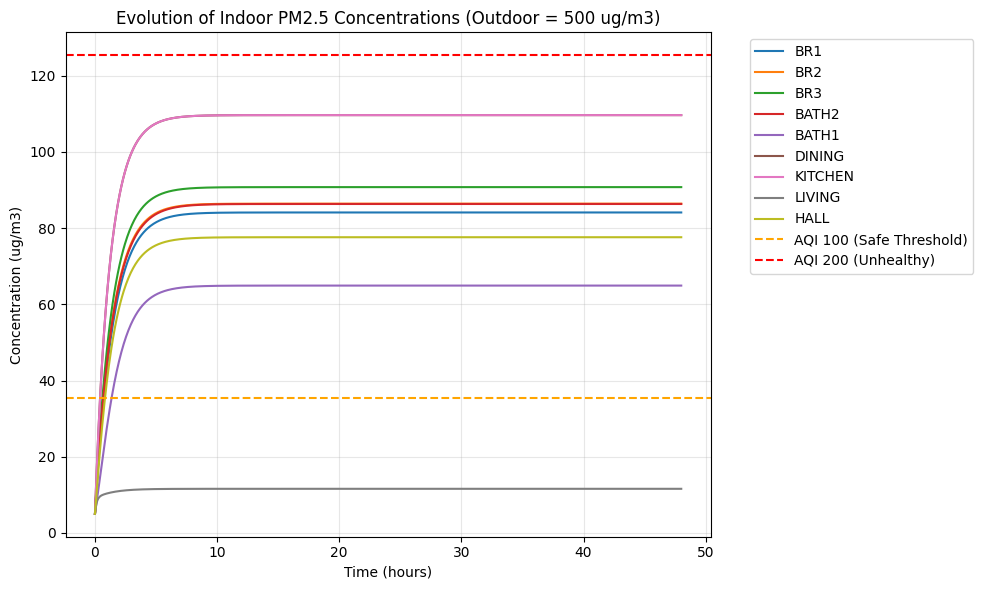

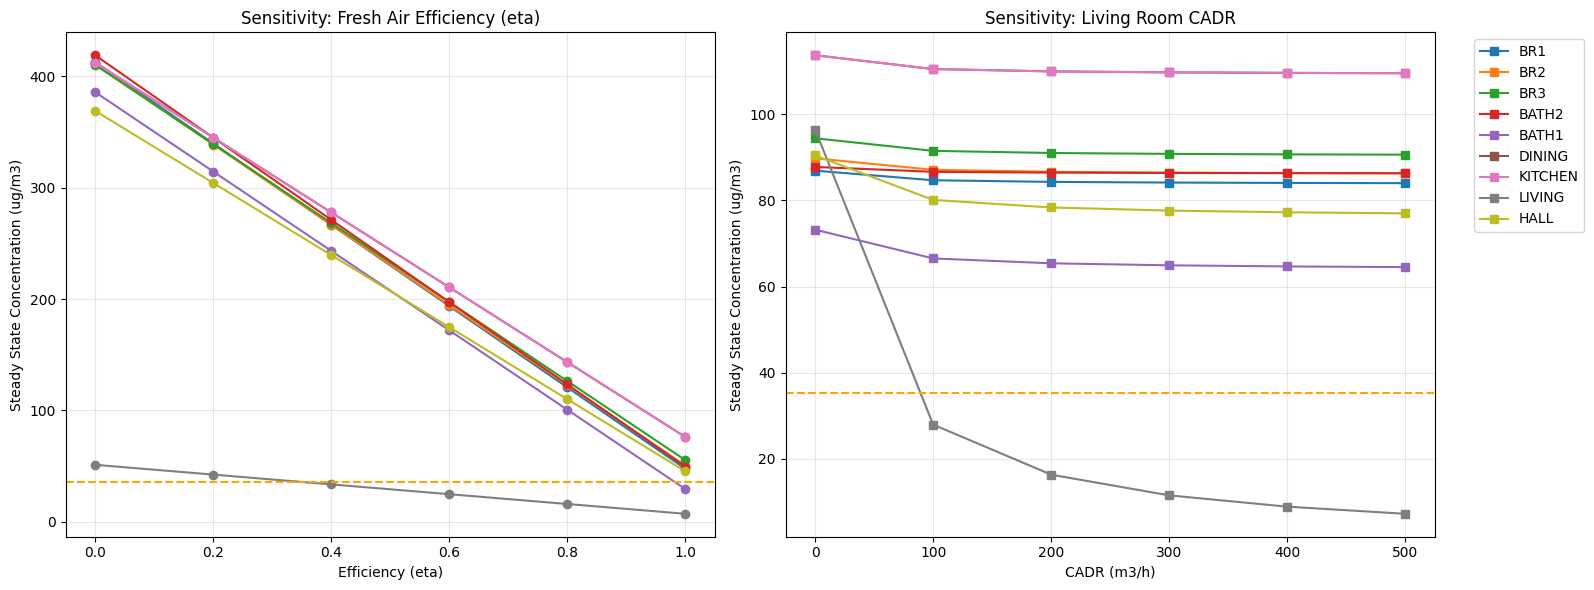

Sensitivity data successfully exported to Sensitivity_Analysis_Results.xlsx


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# =============================================================================
# [cite_start]1. Initialization and Constants [cite: 81, 83, 89, 93, 107]
# =============================================================================
# Node mapping (1-10 mapped to Python indices 0-9)
NODE_MAP = {
    'OUTSET': 0,        # Index 1: Outdoor environment
    'BEDROOM1': 1,      # Index 2: Bedroom #1
    'BEDROOM2': 2,      # Index 3: Bedroom #2
    'BEDROOM3': 3,      # Index 4: Bedroom #3
    'BATH2': 4,         # Index 5: Bathroom #2
    'BATH1': 5,         # Index 6: Bathroom #1
    'DININGROOM': 6,    # Index 7: Dining Room
    'KITCHEN': 7,       # Index 8: Kitchen
    'LIVINGROOM': 8,    # Index 9: Living Room
    'HALL_FOYER': 9     # Index 10: Hall/Foyer
}
N_TOTAL = 10
N_ROOMS = 9
ROOM_NAMES = ['BR1', 'BR2', 'BR3', 'BATH2', 'BATH1', 'DINING', 'KITCHEN', 'LIVING', 'HALL']

# Environmental parameters
C1 = 500.0           # Outdoor concentration (ug/m3) [cite: 80]
C_INIT = 5.0         # Initial indoor concentration (ug/m3) [cite: 83]
K_DEP = 0.1          # Deposition coefficient k (h-1) [cite: 88, 89]
LAMBDA_NI = 0.5      # Fresh air exchange rate (h-1) 

# Baseline for Sensitivity Analysis
BASE_ETA = 0.9       # Fresh air purification efficiency eta [cite: 107]
BASE_CADR = 300.0    # Living room CADR (m3/h) [cite: 107]

# Room Volumes V (m3)
# Index 0 is OUTSET (infinite volume, placeholder np.inf)
V = np.array([np.inf, 47.3, 42.9, 37.2, 14.6, 9.1, 30.4, 30.4, 47.3, 26.0])

# Air Flow Matrix Q (m3/h)
# Q[j, i] represents volume flow rate from node j to node i
Q_data = [
    [0, 3, 3, 3, 1, 0, 4, 4, 4, 1],   # Outdoor (R1)
    [3, 0, 0, 0, 10, 0, 0, 0, 0, 10], # Bedroom 1 (R2)
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Bedroom 2 (R3)
    [3, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Bedroom 3 (R4)
    [1, 10, 0, 0, 0, 0, 0, 0, 0, 0],  # Bathroom 2 (R5)
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Bathroom 1 (R6)
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Dining Room (R7)
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Kitchen (R8)
    [4, 0, 0, 0, 0, 0, 0, 0, 0, 10],  # Living Room (R9)
    [1, 10, 10, 10, 0, 10, 10, 10, 10, 0] # Hall/Foyer (R10)
]
Q = np.array(Q_data)

# =============================================================================
# [cite_start]2. ODE Model Definition [cite: 104, 107]
# =============================================================================
def air_quality_model(C_rooms, t, V, Q, C1, K_DEP, ETA, LAMBDA_NI, CADR_VEC):
    """
    C_rooms: Vector of 9 indoor concentrations.
    Returns: Derivatives dC/dt for 9 rooms.
    """
    C_full = np.concatenate(([C1], C_rooms)) # nodes 1-10
    dCdt = np.zeros(N_ROOMS)

    for i in range(1, 10): # Iterating indoor rooms (1-9 in Python index)
        # 1. Inter-room exchange: Inflow - Outflow
        in_term = np.sum(Q[:, i] * C_full) / V[i]
        out_term = np.sum(Q[i, :] * C_full[i]) / V[i]

        # 2. Mechanical ventilation (Fresh Air)
        # Input (filtered): (1-eta) * Lambda_N * C1
        # Exhaust (to maintain pressure): Lambda_N * Ci
        fresh_in = (1 - ETA) * LAMBDA_NI * C1
        fresh_out = LAMBDA_NI * C_full[i]

        # 3. Removal terms (Deposition + Purification)
        # Removal = (k + CADR/Vi) * Ci
        removal = (K_DEP + CADR_VEC[i] / V[i]) * C_full[i]

        # Final ODE summary
        dCdt[i-1] = in_term - out_term + fresh_in - fresh_out - removal

    return dCdt

# =============================================================================
# 3. Baseline Simulation Execution
# =============================================================================
t_span = np.linspace(0, 48, 1000) # Simulating 48 hours
C0 = np.full(N_ROOMS, C_INIT)    # Initial concentration [cite: 83]

# CADR distribution (only Living Room has a purifier)
cadr_vec_base = np.zeros(N_TOTAL)
cadr_vec_base[NODE_MAP['LIVINGROOM']] = BASE_CADR

# Solve ODE
sol_base = odeint(air_quality_model, C0, t_span,
                  args=(V, Q, C1, K_DEP, BASE_ETA, LAMBDA_NI, cadr_vec_base))

# Plotting: Baseline Concentration Evolution (English)
plt.figure(figsize=(10, 6))
for i in range(N_ROOMS):
    plt.plot(t_span, sol_base[:, i], label=ROOM_NAMES[i])
plt.axhline(y=35.4, color='orange', linestyle='--', label='AQI 100 (Safe Threshold)')
plt.axhline(y=125.4, color='red', linestyle='--', label='AQI 200 (Unhealthy)')
plt.title("Evolution of Indoor PM2.5 Concentrations (Outdoor = 500 ug/m3)")
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (ug/m3)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('baseline_simulation_en.png')

# =============================================================================
# 4. Sensitivity Analysis and Plotting (English)
# =============================================================================
# Analysis for eta (0 to 1) and CADR (0 to 500)
eta_range = np.linspace(0, 1, 6)
cadr_range = np.linspace(0, 500, 6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# A. Efficiency (eta) Sensitivity Plot
eta_results = []
for eta in eta_range:
    sol = odeint(air_quality_model, C0, t_span,
                 args=(V, Q, C1, K_DEP, eta, LAMBDA_NI, cadr_vec_base))
    eta_results.append(sol[-1, :])
eta_df = pd.DataFrame(eta_results, columns=ROOM_NAMES)

for i in range(N_ROOMS):
    ax1.plot(eta_range, eta_df[ROOM_NAMES[i]], marker='o', label=ROOM_NAMES[i])
ax1.axhline(y=35.4, color='orange', linestyle='--')
ax1.set_title('Sensitivity: Fresh Air Efficiency (eta)')
ax1.set_xlabel('Efficiency (eta)')
ax1.set_ylabel('Steady State Concentration (ug/m3)')
ax1.grid(True, alpha=0.3)

# B. CADR Sensitivity Plot
cadr_results = []
for cadr in cadr_range:
    test_cadr_vec = np.zeros(N_TOTAL)
    test_cadr_vec[NODE_MAP['LIVINGROOM']] = cadr
    sol = odeint(air_quality_model, C0, t_span,
                 args=(V, Q, C1, K_DEP, BASE_ETA, LAMBDA_NI, test_cadr_vec))
    cadr_results.append(sol[-1, :])
cadr_df = pd.DataFrame(cadr_results, columns=ROOM_NAMES)

for i in range(N_ROOMS):
    ax2.plot(cadr_range, cadr_df[ROOM_NAMES[i]], marker='s', label=ROOM_NAMES[i])
ax2.axhline(y=35.4, color='orange', linestyle='--')
ax2.set_title('Sensitivity: Living Room CADR')
ax2.set_xlabel('CADR (m3/h)')
ax2.set_ylabel('Steady State Concentration (ug/m3)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('combined_sensitivity_analysis_en.png')
plt.show()

# 导出数据到 Excel（全部数据）
# =============================================================================
# 6. Export Sensitivity Analysis Data to Excel
# =============================================================================

# Define the file name
excel_filename = 'Sensitivity_Analysis_Results.xlsx'

# Use Pandas ExcelWriter to save multiple dataframes into one file
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    # Export ETA (Fresh Air Efficiency) results
    # Each row represents a different eta value, columns are room steady-state concentrations
    eta_df.to_excel(writer, sheet_name='ETA_Efficiency_Impact', index=False)
    
    # Export CADR (Living Room Purifier) results
    # Each row represents a different CADR value
    cadr_df.to_excel(writer, sheet_name='LivingRoom_CADR_Impact', index=False) 
    

print(f"Sensitivity data successfully exported to {excel_filename}")